# Notebook de Estudo do BERT como encoder

Do enunciado do EP:

> você poderá usar qualquer outro método que quiser para adaptar o BERT para esta tarefa de
geração de texto, ou até mesmo propor uma alteração deste método.

In [1]:
!nvidia-smi

Mon Dec 21 12:48:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |      0MiB / 16160MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
sys.path.append('..')

In [3]:
from code_utils.metrics import decode_text, generate_sequences, report_linguistic_metrics
from code_utils.models.bert.training import define_decoder_tokenization_layers, define_full_model, tokenize_encoder
from code_utils.models.bert.inference import encoder_inference_model, decoder_inference_model
from code_utils.preprocessing.data_preprocessing import process_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /var/fasttmp/abarbosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Attention, Bidirectional, Dense, Embedding, Input, GRU
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel
import pandas as pd

In [5]:
DATA_PATH = "../data/b2w-10k.csv"
REVIEW_TITLE = "review_title"
REVIEW_TEXT = "review_text"
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
(
    encoder_train,
    encoder_test,
    decoder_train,
    decoder_test,
    decoder_label_train,
    decoder_label_test,
) = process_data(DATA_PATH, REVIEW_TEXT, REVIEW_TITLE)

In [7]:
enc_sequence = [len(txt[0].split()) for txt in encoder_train]
np.quantile(enc_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([  9.,  10.,  12.,  13.,  15.,  18.,  23.,  30.,  45., 117.])

In [8]:
dec_sequence = [len(txt[0].split()) for txt in decoder_train]
np.quantile(dec_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([ 3.  ,  3.  ,  4.  ,  4.  ,  4.  ,  5.  ,  5.  ,  6.  ,  8.  ,
       14.02])

In [9]:
ENCODER_SEQ_LENGTH = 65
DECODER_SEQ_LENGTH = 10

In [10]:
(
    tokenizer_layer_decoder,
    tokenizer_layer_decoder_inference
) = define_decoder_tokenization_layers(decoder_train, DECODER_SEQ_LENGTH)

In [11]:
VOCAB_SIZE_decoder = len(tokenizer_layer_decoder.get_vocabulary()) + 2
BATCH_SIZE = 128
EPOCHS=50
EMBED_DIM = 64  # tamanho do Embedding de cada token
BERT_DIM = 768
BERT_MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
LEARNING_RATE=0.001

In [12]:
encoder_train = tokenize_encoder(
    encoder_train, BERT_MODEL_NAME, ENCODER_SEQ_LENGTH
)
encoder_test =tokenize_encoder(
    encoder_test, BERT_MODEL_NAME, ENCODER_SEQ_LENGTH
)

In [13]:
# Encoder definition
input_text_encoder = Input(
    shape=(ENCODER_SEQ_LENGTH,), dtype=tf.int32, name="input_text"
)
encoder_model = TFBertModel.from_pretrained(
    BERT_MODEL_NAME,
    output_hidden_states=False,
    output_attentions=False,
    from_pt=True,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [14]:
# Decoder definition
input_text_decoder = Input(shape=(None,), dtype=tf.string, name="decoder_input")
emb_dec_layer = Embedding(VOCAB_SIZE_decoder, EMBED_DIM, name="decoder_embedding")
decoder_model = GRU(
    BERT_DIM, return_sequences=True, return_state=True, name="decoder_rnn"
)
attention_layer = Attention(name="attention", causal=True)
decoder_dense = Dense(VOCAB_SIZE_decoder, activation="softmax", name="dense_layer")

In [15]:
## Preprocessing step
tokenized_decoder = tokenizer_layer_decoder(input_text_decoder)
# embedding layer
dec_emb = emb_dec_layer(tokenized_decoder)

In [16]:
model =  define_full_model(input_text_encoder,encoder_model,
                           input_text_decoder,
                           dec_emb, decoder_model,
                           attention_layer, decoder_dense
                      )

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_vectorizer (TextVectori (None, 10)           0           decoder_input[0][0]              
__________________________________________________________________________________________________
input_text (InputLayer)         [(None, 65)]         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 10, 64)       198080      decoder_vectorizer[0][0]         
______________________________________________________________________________________________

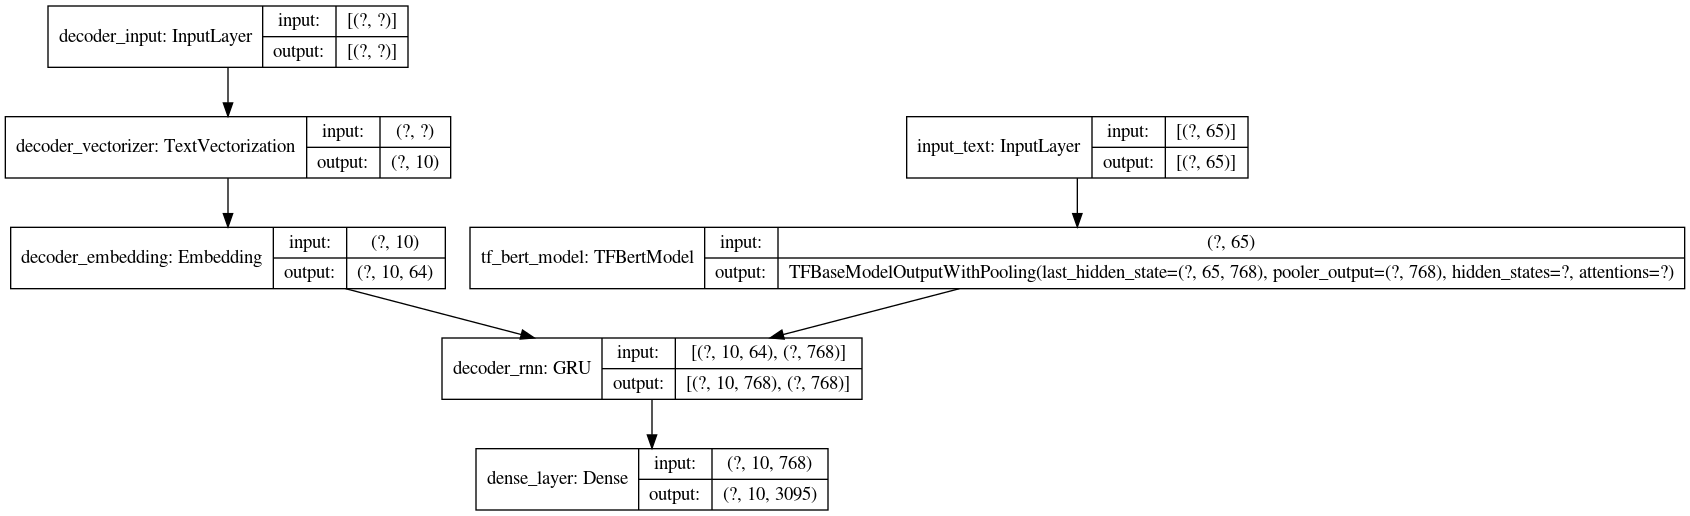

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    optimizer=opt,
    loss={"dense_layer": "sparse_categorical_crossentropy"},
    metrics={"dense_layer": "accuracy"},
)

In [20]:
print(f"Forma do Dataset de Treinamento: {encoder_train.shape}")

Forma do Dataset de Treinamento: (7999, 65)


In [21]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

history = model.fit(
    [encoder_train, decoder_train],
    tokenizer_layer_decoder(decoder_label_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_split=0.1
)

Epoch 1/50
57/57 [==============================] - 45s 783ms/step - loss: 2.7748 - accuracy: 0.6166 - val_loss: 2.1590 - val_accuracy: 0.6509
Epoch 2/50
57/57 [==============================] - 33s 572ms/step - loss: 1.8576 - accuracy: 0.6992 - val_loss: 1.8940 - val_accuracy: 0.7035
Epoch 3/50
57/57 [==============================] - 33s 571ms/step - loss: 1.7061 - accuracy: 0.7212 - val_loss: 1.8334 - val_accuracy: 0.7156
Epoch 4/50
57/57 [==============================] - 33s 572ms/step - loss: 1.6257 - accuracy: 0.7287 - val_loss: 1.7822 - val_accuracy: 0.7188
Epoch 5/50
57/57 [==============================] - 32s 568ms/step - loss: 1.5429 - accuracy: 0.7389 - val_loss: 1.7312 - val_accuracy: 0.7361
Epoch 6/50
57/57 [==============================] - 32s 567ms/step - loss: 1.4748 - accuracy: 0.7453 - val_loss: 1.7003 - val_accuracy: 0.7386
Epoch 7/50
57/57 [==============================] - 32s 570ms/step - loss: 1.4181 - accuracy: 0.7498 - val_loss: 1.6828 - val_accuracy: 0.7400

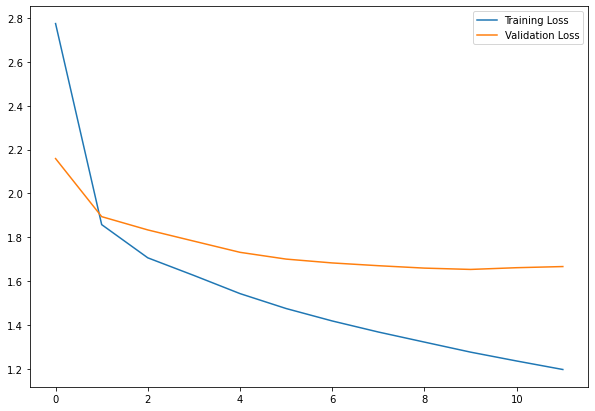

In [22]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

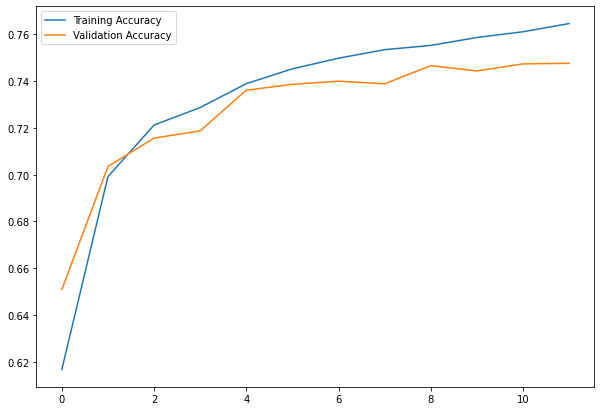

In [23]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['accuracy'],label='Training Accuracy')
b, = plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(handles=[a,b])
plt.show()

In [24]:
test_loss, test_acc = model.evaluate([encoder_test, decoder_test],
                                      tokenizer_layer_decoder(decoder_label_test),
                                      batch_size=128)

16/16 [==============================] - 3s 187ms/step - loss: 1.6155 - accuracy: 0.7548


In [25]:
tokenized_decoder_inference = tokenizer_layer_decoder_inference(input_text_decoder)
dec_emb_embedding_inference = emb_dec_layer(tokenized_decoder_inference)

In [26]:
encoder_inference = encoder_inference_model(input_text_encoder, encoder_model)

In [27]:
decoder_inference = decoder_inference_model(
    decoder_embedding=dec_emb_embedding_inference,
    target_text=input_text_decoder,
    latent_dim=BERT_DIM,
    encoder_sequence_length=ENCODER_SEQ_LENGTH,
    decoder_model=decoder_model,
    attention_layer=attention_layer,
    decoder_dense=decoder_dense,
)

In [28]:
sentences = generate_sequences(
    encoder_test,
    decoder_label_test,
    100,
    encoder_inference,
    decoder_inference,
    DECODER_SEQ_LENGTH,
    tokenizer_layer_decoder_inference,
)

Gerando Predições: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


In [29]:
bleu_metric, nist_metric, meteor_metric = report_linguistic_metrics(sentences)

/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the B

In [30]:
pd.DataFrame([test_acc, bleu_metric, nist_metric, meteor_metric]).T.rename(columns={0:'accuracy',
                                                                                    1:'bleu score',
                                                                                    2:'nist score',
                                                                                    3:'meteor score'})

,accuracy,bleu score,nist score,meteor score
0,0.75485,1.442265e-231,0.290256,0.0
